# XGBoost Baseline - LB 0.678

XGBoost로 18개 질문 각각에 대해 그룹 KFold 모델을 교육합니다.   
CV 점수는 0.678점입니다. KFold 모델 중 하나를 사용하여 테스트를 추론합니다.  
xgboost를 위해 더 많은 기능을 엔지니어링하거나 다른 모델(다른 ML 모델 및/또는 RNN 및/또는 Transformer)을   
시도하여 CV 및 LB를 개선할 수 있습니다. 또한 더 많은 KFold 모델을 사용하거나 모든 데이터(및 KFold 교차 검증에서   
발견한 하이퍼 파라미터)를 사용하여 하나의 모델을 교육하여 LB를 개선할 수 있습니다.  

In [4]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Load Train Data and Labels

In [5]:
train = pd.read_csv('/Users/leebyeongho/Downloads/predict-student-performance-from-game-play/train.csv')
print(train.shape)
train.head()

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


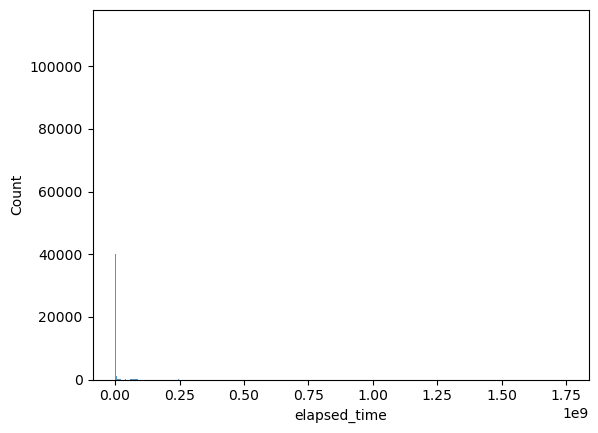

In [29]:
import seaborn as sns
sns.histplot(train.elapsed_time);

In [30]:
targets = pd.read_csv('/Users/leebyeongho/Downloads/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print(targets.shape)
targets.head()

(212022, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


# Columns

session_id - 이벤트가 발생한 세션의 ID  
index - 세션의 이벤트 인덱스  
elapsed_time - 세션 시작과 이벤트가 기록된 시간 사이에 경과된 시간(in milliseconds)  
event_name - 이벤트 유형의 이름  
name - 이벤트 이름(예: notebook_click이 노트북을 열거나 닫는 중인지 식별)  
level - 이벤트가 발생한 게임의 레벨(0~22)  
page - 이벤트의 페이지 번호(노트북 관련 이벤트에만 해당)  
room_coor_x - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
room_coor_y - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_x - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_y - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
hover_duration - 호버가 발생한 시간(in milliseconds)(호버 이벤트에만 해당)  
text - 이 이벤트 동안 플레이어에게 표시되는 텍스트  
fqid - 이벤트의 완전한 ID  
room_fqid - 이벤트가 발생한 방의 정규화된 ID  
text_fqid - 정규화된 ID  
fullscreen - 플레이어가 전체 화면 모드인지 여부  
hq - 게임이 고품질인지 여부  
음악 - 게임 음악이 켜져 있는지 여부  
level_group - 레벨 그룹 및 질문 그룹 - 이 행은 (0-4, 5-12, 13-22)에 속합니다.  

# Feature Engineer

기본적인 Aggregate 기능을 만듭니다. CV와 LB를 강화하기 위해 더 많은 기능을 만들어 보십시오!

In [7]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [8]:
train['event_name'].value_counts().index

Index(['navigate_click', 'person_click', 'cutscene_click', 'object_click',
       'object_hover', 'map_hover', 'notification_click', 'notebook_click',
       'map_click', 'observation_click', 'checkpoint'],
      dtype='object')

## CATS     

event_name - 이벤트 유형의 이름  
name - 이벤트 이름(예: notebook_click이 노트북을 열거나 닫는 중인지 식별)  
fqid - 이벤트의 완전한 ID  
room_fqid - 이벤트가 발생한 방의 정규화된 ID  
text_fqid - 정규화된 ID  

## NUMS  

elapsed_time - 세션 시작과 이벤트가 기록된 시간 사이에 경과된 시간(밀리초)  
level - 이벤트가 발생한 게임의 레벨(0~22)  
page - 이벤트의 페이지 번호(노트북 관련 이벤트에만 해당)  
room_coor_x - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
room_coor_y - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_x - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_y - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
hover_duration - 호버가 발생한 시간(밀리초)(호버 이벤트에만 해당)  

## 안 쓴 특성   
index - 세션의 이벤트 인덱스  
text - 이 이벤트 동안 플레이어에게 표시되는 텍스트  
fullscreen - 플레이어가 전체 화면 모드인지 여부  
hq - 게임이 고품질인지 여부  
음악 - 게임 음악이 켜져 있는지 여부  

## feature_engineer
level_group - 레벨 그룹 및 질문 그룹 - 이 행은 (0-4, 5-12, 13-22)에 속합니다.  
session_id - 이벤트가 발생한 세션의 ID  

In [9]:
def feature_engineer(train):
    
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [10]:
%%time
df = feature_engineer(train)
print(df.shape)
df.head()

(35337, 32)
CPU times: user 34.1 s, sys: 1.22 s, total: 35.3 s
Wall time: 35.4 s


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,14155937
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347170,...,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,437052322
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,105732736
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045960,...,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,13571045
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762282,...,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3241011333


In [11]:
# import seaborn as sns
# features = df.columns
# corr_df = df[features].corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(corr_df, annot=True);

# Train XGBoost Model

18개의 질문 각각에 대해 하나의 모델을 훈련시킵니다.   
또한, level_groups = '0-4'의 데이터를 사용하여 질문 1-3에 대한 모델을 교육하고,  
질문 4-13에 대한 레벨 그룹 '5-12'와 질문 14-18에 대한 레벨 그룹 '13-22'를 사용합니다.   
왜냐하면 이것은 테스트 추론 중에 카글의 추론 API로부터 우리가 (해당 질문을 예측하기 위해)   
얻는 데이터이기 때문입니다. 이전 level_groups에서 사용자의 이전 데이터를 저장하고   
이를 사용하여 미래 level_groups를 예측하여 모델을 개선할 수 있습니다.  

In [12]:
FEATURES = df.columns[1:]
print(f'{len(FEATURES)}개의 특성')
ALL_USERS = df.index.unique()
print(f'{len(ALL_USERS)}명의 유저 정보')

31개의 특성
11779명의 유저 정보


In [23]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('')
    print('Fold',i+1)
    print('')
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4
    }
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=4: grp = '0-4'
        elif t<=12: grp = '5-12'
        else: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()


Fold 1

1(162), 2(145), 3(94), 4(144), 5(79), 6(169), 7(110), 8(75), 9(130), 10(172), 11(117), 12(73), 13(170), 14(130), 15(168), 16(85), 17(85), 18(145), 

Fold 2

1(149), 2(125), 3(131), 4(83), 5(79), 6(175), 7(187), 8(77), 9(113), 10(137), 11(60), 12(68), 13(135), 14(77), 15(192), 16(66), 17(43), 18(89), 

Fold 3

1(73), 2(111), 3(107), 4(88), 5(57), 6(74), 7(133), 8(50), 9(103), 10(111), 11(59), 12(83), 13(135), 14(181), 15(178), 16(88), 17(82), 18(139), 

Fold 4

1(194), 2(124), 3(98), 4(136), 5(128), 6(110), 7(94), 8(38), 9(82), 10(101), 11(80), 12(90), 13(107), 14(142), 15(111), 16(51), 17(67), 18(178), 

Fold 5

1(104), 2(136), 3(98), 4(78), 5(60), 6(127), 7(138), 8(54), 9(115), 10(104), 11(61), 12(90), 13(128), 14(141), 15(186), 16(72), 17(63), 18(83), 


# Compute CV Score

예측 확률을 1과 0으로 변환해야 합니다. 경기 측정 기준은 정밀도와 리콜의 조화 평균인 F1 점수입니다. 
1을 예측할 때 p > 임계값에 대한 최적의 임계값과 F1 점수를 최대화하기 위해 0을 예측할 때의 임계값을 알아보겠습니다.

In [24]:
# True 레이블을 18개의 열로 구성된 데이터 프레임에 넣습니다
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [25]:
# 확률을 1과 0으로 변환하기 위한 최적의 임계값을 찾습니다
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold
print(f'Best 임계점: {best_threshold:.2f}')
print(f'Best F1_score: {best_score:.4f}')

Best 임계점: 0.63
Best F1_score: 0.6766


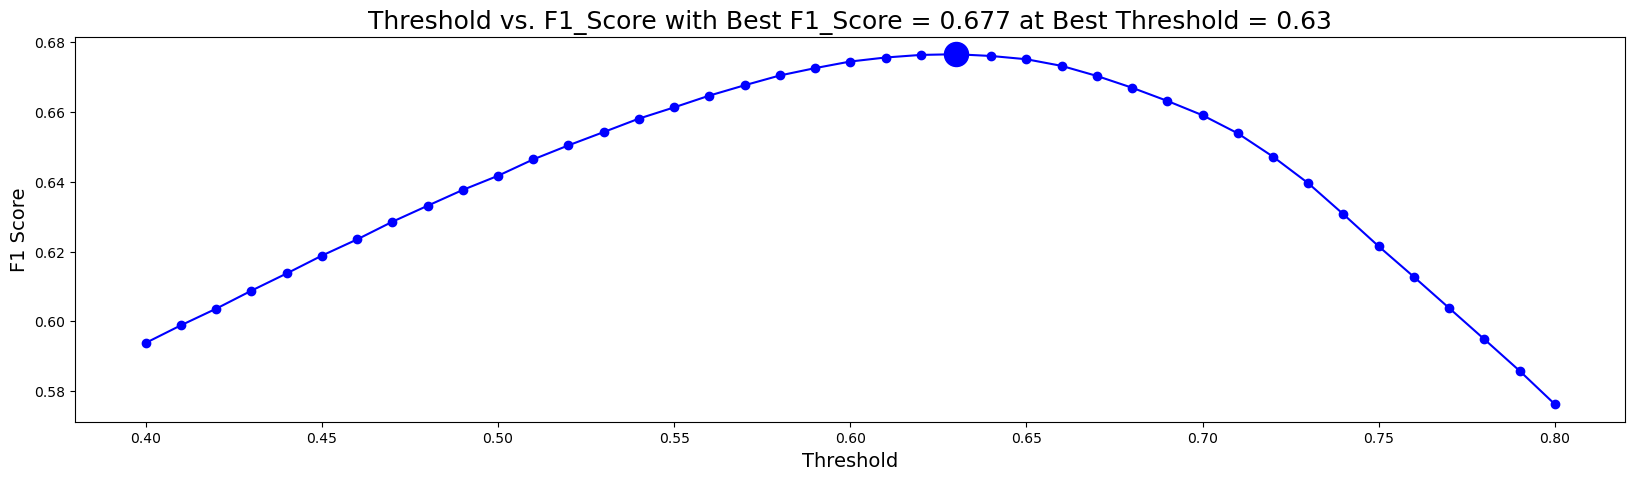

In [27]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [28]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5939042187741084
Q1: F1 = 0.4945936668669012
Q2: F1 = 0.4885585107441168
Q3: F1 = 0.5479319035607266
Q4: F1 = 0.5613938834640069
Q5: F1 = 0.6093309483827324
Q6: F1 = 0.5915376418704729
Q7: F1 = 0.5289688866100604
Q8: F1 = 0.6040180756646938
Q9: F1 = 0.502984931809264
Q10: F1 = 0.5931196681974658
Q11: F1 = 0.49610501048311995
Q12: F1 = 0.44462781632097453
Q13: F1 = 0.610038349985836
Q14: F1 = 0.5068607209459277
Q15: F1 = 0.4529035000467382
Q16: F1 = 0.541762328033037
Q17: F1 = 0.49394125807793826
==> Overall F1 = 0.6765863786591633
